<a href="https://colab.research.google.com/github/eursamajor/Aksara/blob/main/Batak_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT DATA AND DATA AUGMENTATION

In [3]:
import os
import shutil
import requests
import zipfile
from io import BytesIO
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt

In [4]:
dataset_dir = './drive/MyDrive/Aksara/Batak'

# new dir utk taroh 3 data
base_dir = './dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for class_name in os.listdir(dataset_dir):
        os.makedirs(os.path.join(directory, class_name), exist_ok=True)

# split data
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)

    train_images, temp_images = train_test_split(images, test_size=0.4, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

#augment
img_size = (224, 224)
batch_size = 32

# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=40,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest'
#                                    )
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 1140 images belonging to 19 classes.
Found 380 images belonging to 19 classes.
Found 380 images belonging to 19 classes.


### DEFINE MODEL

In [5]:
def create_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = create_model(base_model)

17225924/17225924 [==============================] - 1s 0us/step


### TRAIN AND EVALUATION

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(train_generator, validation_data=val_generator, epochs=30)

test_loss, test_acc = model.evaluate(test_generator)

Epoch 1/30
36/36 [==============================] - 12s 130ms/step - loss: 7.6856 - accuracy: 0.7088 - val_loss: 0.8340 - val_accuracy: 0.9526
Epoch 2/30
36/36 [==============================] - 3s 91ms/step - loss: 0.6810 - accuracy: 0.9570 - val_loss: 0.4153 - val_accuracy: 0.9763
Epoch 3/30
36/36 [==============================] - 3s 79ms/step - loss: 0.3477 - accuracy: 0.9754 - val_loss: 0.6508 - val_accuracy: 0.9763
Epoch 4/30
36/36 [==============================] - 3s 79ms/step - loss: 0.2274 - accuracy: 0.9728 - val_loss: 0.3735 - val_accuracy: 0.9842
Epoch 5/30
36/36 [==============================] - 4s 94ms/step - loss: 0.1905 - accuracy: 0.9833 - val_loss: 0.2996 - val_accuracy: 0.9737
Epoch 6/30
36/36 [==============================] - 3s 72ms/step - loss: 0.3068 - accuracy: 0.9816 - val_loss: 0.5103 - val_accuracy: 0.9737
Epoch 7/30
36/36 [==============================] - 3s 92ms/step - loss: 0.2027 - accuracy: 0.9825 - val_loss: 0.5546 - val_accuracy: 0.9684
Epoch 8/30


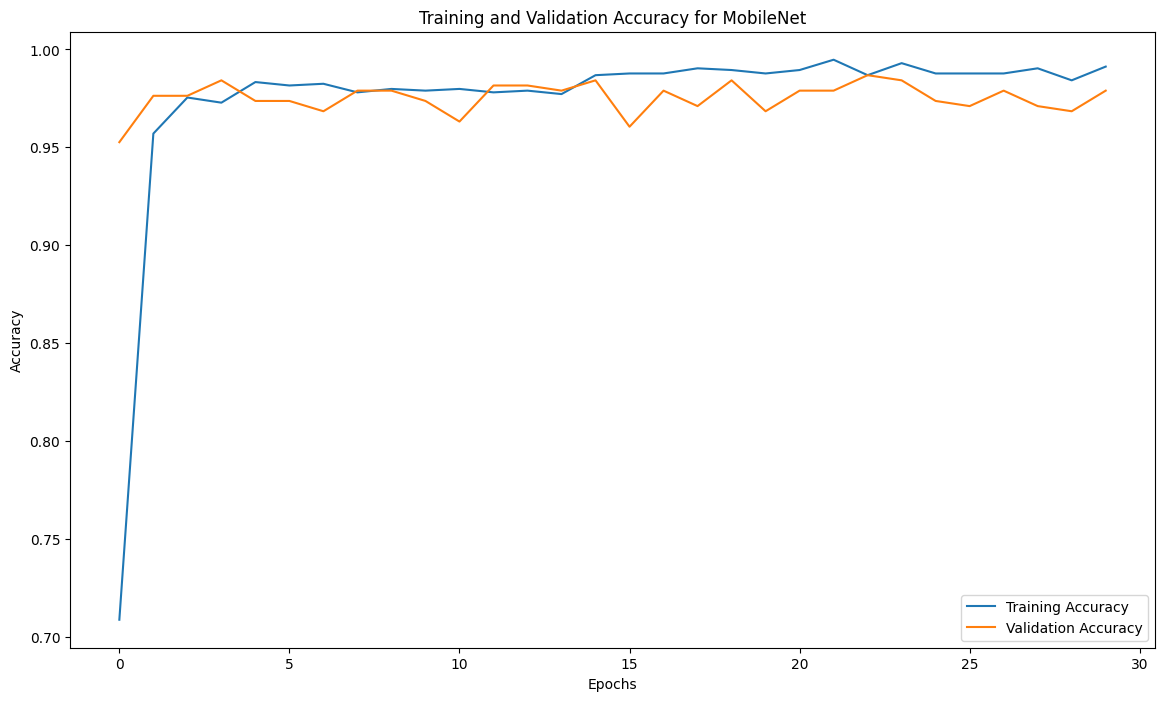

In [7]:
# Plotting Accuracy and Validation Accuracy
plt.figure(figsize=(14, 8))
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for MobileNet')
plt.grid(False)
plt.show()